# Project: Predicting Diabetes Onset FHIR EHR Data
### Notebook: 04_Modeling.ipynb
### Purpose: Predictive Modeling for Diabetes Onset

In [121]:
# import libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [13]:
# load data
df = pd.read_csv('/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Data_Diabetes_Prediction/Cleaned/df_final.csv')

In [29]:
# Missingness Validaiton
df.isna().sum().sum()

0

In [32]:
# inspect df
df.head(3)

,patient_id,label,bmi_mean,body_height_mean,body_weight_mean,bun_mean,heart_rate_mean,bmi_last_value,body_height_last_value,body_weight_last_value,...,body_height_days_since_last,body_weight_days_since_last,bun_days_since_last,heart_rate_days_since_last,hdl_cholesterol_mean_missing,ldl_cholesterol_mean_missing,total_cholesterol_mean_missing,total_labs,unique_labs,label_name
0,011dcab7-8543-84f8-5842-fa84972bbf25,1,29.750,186.0,102.90,15.0,72.0,29.75,186.0,102.9,...,6.0,6.0,6.0,6.0,0,0,0,8,8,Diabetic
1,019dd1e7-5307-5d8a-c04f-8693c0ebdf35,0,15.995,98.2,15.45,15.0,79.0,15.57,100.0,15.6,...,139.0,139.0,139.0,139.0,1,1,1,10,5,Non-Diabetic
2,02aa3df1-6e90-e28f-abf3-8a5647f49707,0,22.530,185.4,77.40,16.0,96.0,22.53,185.4,77.4,...,175.0,175.0,175.0,175.0,1,1,1,6,6,Non-Diabetic


In [21]:
# Class proportion

df['label'].value_counts(normalize=True)

label
0    0.849873
1    0.150127
Name: proportion, dtype: float64

In [54]:
# define X and Y for training

X = df.drop(columns=['patient_id', 'label', 'label_name'])
y = df['label']

In [56]:
# confirm separation of x and y 

X.head(1), y.head(1)

(   bmi_mean  body_height_mean  body_weight_mean  bun_mean  heart_rate_mean  \
 0     29.75             186.0             102.9      15.0             72.0   
 
    bmi_last_value  body_height_last_value  body_weight_last_value  \
 0           29.75                   186.0                   102.9   
 
    bun_last_value  heart_rate_last_value  ...  bmi_days_since_last  \
 0            15.0                   72.0  ...                  6.0   
 
    body_height_days_since_last  body_weight_days_since_last  \
 0                          6.0                          6.0   
 
    bun_days_since_last  heart_rate_days_since_last  \
 0                  6.0                         6.0   
 
    hdl_cholesterol_mean_missing  ldl_cholesterol_mean_missing  \
 0                             0                             0   
 
    total_cholesterol_mean_missing  total_labs  unique_labs  
 0                               0           8            8  
 
 [1 rows x 25 columns],
 0    1
 Name: label, dtype:

In [58]:
# train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

In [123]:
# pipeline for model training

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear'
    ))
])

### Logistic Regression Model

In [125]:
# train logistic regression model 

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

In [127]:
# Predoct on test data

y_probs_lr = pipe_lr.predict_proba(X_test)[:,1]

In [111]:
# baseline model evaluation 
# ROC AUC score

roc_auc = roc_auc_score(y_test, y_probs_lr)
roc_auc

0.7523809523809524

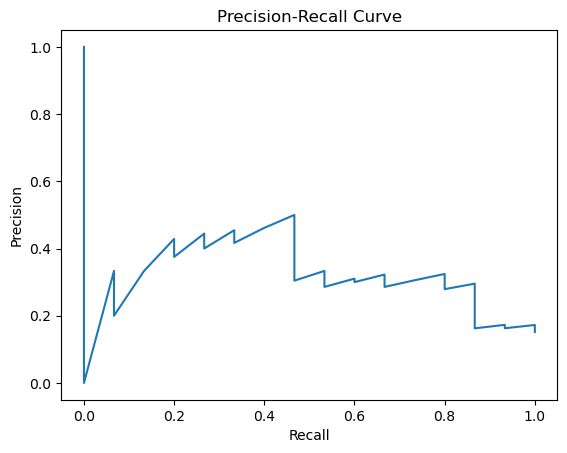

In [113]:
# precision and recall 

precision, recall, thresholds = precision_recall_curve(y_test, y_probs_lr)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [115]:
# classification Report at chosen threshold

threshold = 0.3
y_pred_lr = (y_probs >= threshold).astype(int)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.94      0.35      0.50        84
           1       0.19      0.87      0.31        15

    accuracy                           0.42        99
   macro avg       0.56      0.61      0.41        99
weighted avg       0.82      0.42      0.48        99



In [129]:
# fitted ccoefficients

coef_df_lr = pd.DataFrame({
    'feature': X.columns,
    'coef': pipe_lr.named_steps['model'].coef_[0]
}).sort_values(by='coef', ascending=False)

coef_df_lr


,feature,coef
9,heart_rate_last_value,0.984777
3,bun_mean,0.847661
24,unique_labs,0.493562
12,body_weight_count_value,0.215915
7,body_weight_last_value,0.196813
10,bmi_count_value,0.141287
11,body_height_count_value,0.141287
2,body_weight_mean,0.132103
22,total_cholesterol_mean_missing,0.096315
21,ldl_cholesterol_mean_missing,0.096315


### Random Forest Model

In [91]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       n_estimators=300, random_state=42)

In [97]:
y_proba_rf = rf.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

roc_auc_rf

0.8404761904761904

In [99]:
# Classification Report for Random Forest

threshold = 0.3
y_pred_rf = (y_proba_rf >= threshold).astype(int)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84        84
           1       0.37      0.87      0.52        15

    accuracy                           0.76        99
   macro avg       0.67      0.80      0.68        99
weighted avg       0.88      0.76      0.79        99



In [119]:
importances_rf = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

importances_rf.head(15)


,feature,importance
18,bun_days_since_last,0.139131
15,bmi_days_since_last,0.130676
19,heart_rate_days_since_last,0.119408
16,body_height_days_since_last,0.102014
17,body_weight_days_since_last,0.087954
5,bmi_last_value,0.057793
0,bmi_mean,0.056960
2,body_weight_mean,0.045591
9,heart_rate_last_value,0.043090
7,body_weight_last_value,0.042026


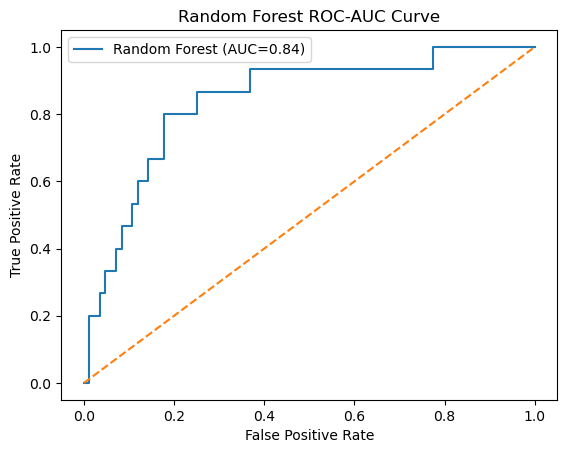

In [107]:
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC={roc_auc_rf:.2f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC-AUC Curve')
plt.legend()
plt.show()


In [131]:
# save models
joblib.dump(pipe_lr,
           '/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Models/logistic_model.joblib')
joblib.dump(rf,
           '/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Models/random_forest_model.joblib')

['/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Models/random_forest_model.joblib']

In [133]:
# save test data and predictions 
pd.Series(y_test, name='y_test').to_csv('/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Predictions/y_test.csv',
                                        index=False)
pd.Series(y_probs_lr, name='y_proba_lr').to_csv('/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Predictions/y_proba_lr.csv',
                                        index=False)
pd.Series(y_proba_rf, name='y_proba_rf').to_csv('/Users/sanasiddiqui/Desktop/Current Desktop/Data Portfolio Projects/Diabetes_Onset_Prediction_FHIR/Artifacts/Predictions/y_proba_rf.csv',
                                        index=False)